In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_1 = pd.read_csv('ecommerce_customer_behavior_dataset.csv')
df_2 = pd.read_csv('ecommerce_customer_behavior_dataset_v2.csv')

In [3]:
df_1.iloc[: 3]

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_001337,CUST_01337,2023-01-01,27,Female,Bursa,Toys,54.28,1,0.0,54.28,Debit Card,Mobile,4,14,True,8,5
1,ORD_004885,CUST_04885,2023-01-01,42,Male,Konya,Toys,244.90,1,0.0,244.90,Credit Card,Mobile,11,3,True,3,3
2,ORD_004507,CUST_04507,2023-01-01,43,Female,Ankara,Food,48.15,5,0.0,240.75,Credit Card,Mobile,7,8,True,5,2


In [4]:
df_2.iloc[: 3]

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_000001-1,CUST_00001,2023-05-29,40,Male,Ankara,Books,29.18,1,0.00,29.18,Digital Wallet,Mobile,14,9,True,13,4
1,ORD_000001-2,CUST_00001,2023-10-12,40,Male,Ankara,Home & Garden,644.40,1,138.05,506.35,Credit Card,Desktop,14,8,True,6,2
2,ORD_000001-3,CUST_00001,2023-12-05,40,Male,Ankara,Sports,332.82,5,0.00,1664.10,Credit Card,Mobile,15,10,True,9,4


In [5]:
df_1.shape

(5000, 18)

In [6]:
df_2.shape

(17049, 18)

In [ ]:
# Check if table 1 already contained in Table 2

if df_1['Customer_ID'].isin(df_2['Customer_ID']).all():
    print("Merge not required")
else:
    print("Merge is required, new records dectected.")

Merge not required


Since Table 1 is already in Table 2, I don't need to merge the dataset to avoid duplicated values.

## Data Exploration

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049 entries, 0 to 17048
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order_ID                  17049 non-null  object 
 1   Customer_ID               17049 non-null  object 
 2   Date                      17049 non-null  object 
 3   Age                       17049 non-null  int64  
 4   Gender                    17049 non-null  object 
 5   City                      17049 non-null  object 
 6   Product_Category          17049 non-null  object 
 7   Unit_Price                17049 non-null  float64
 8   Quantity                  17049 non-null  int64  
 9   Discount_Amount           17049 non-null  float64
 10  Total_Amount              17049 non-null  float64
 11  Payment_Method            17049 non-null  object 
 12  Device_Type               17049 non-null  object 
 13  Session_Duration_Minutes  17049 non-null  int64  
 14  Pages_

In [11]:
categorical_features = df_2.columns[df_2.dtypes == object].tolist()

print(categorical_features)

['Order_ID', 'Customer_ID', 'Date', 'Gender', 'City', 'Product_Category', 'Payment_Method', 'Device_Type']


In [15]:
numeric_features = df_2.columns[~(df_2.dtypes == object)].tolist()

print(numeric_features)

['Age', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 'Session_Duration_Minutes', 'Pages_Viewed', 'Is_Returning_Customer', 'Delivery_Time_Days', 'Customer_Rating']


In [17]:
df_2[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,17049.0,34.945745,11.046855,18.00,26.00,35.00,42.00,75.00
Unit_Price,17049.0,447.901689,722.319705,5.05,73.26,174.68,494.57,7900.01
Quantity,17049.0,3.011379,1.417027,1.00,2.00,3.00,4.00,5.00
Discount_Amount,17049.0,69.788135,240.704662,0.00,0.00,0.00,32.71,6538.29
Total_Amount,17049.0,1277.438711,2358.436375,6.21,172.97,455.85,1267.75,37852.05
Session_Duration_Minutes,17049.0,14.535633,2.925524,4.00,13.00,15.00,17.00,26.00
Pages_Viewed,17049.0,9.003109,2.259954,1.00,7.00,9.00,11.00,18.00
Delivery_Time_Days,17049.0,6.503607,3.488787,1.00,4.00,6.00,8.00,25.00
Customer_Rating,17049.0,3.899408,1.128803,1.00,3.00,4.00,5.00,5.00


In [18]:
df_2['Date'] = pd.to_datetime(df_2['Date'])

### Customer Segmentation 

##### Ojective

Group customers into meaningful clusters based on how they behave and spend, not just who they are

We'll focus on

- Purchase behaviour
- Engagement behaviour
- Value-based metrics

In [19]:
df_2['Date'].max()

Timestamp('2024-03-25 00:00:00')

In [20]:
reference_date = df_2['Date'].max() + pd.Timedelta(days=1)

In [22]:
# Customer behavious features per customer

customer_features = df_2.groupby('Customer_ID').agg({
    'Date' : lambda x: (reference_date - x.max()).days,
    'Order_ID': 'count',
    'Total_Amount': 'sum',
    'Discount_Amount': 'mean',
    'Product_Category': 'nunique',
    'Session_Duration_Minutes': 'mean',
    'Pages_Viewed': 'mean',
    'Is_Returning_Customer': 'mean',
    'Customer_Rating': 'mean'
})

customer_features.columns = [
    'recency',
    'frequency',
    'monetary',
    'avg_discount',
    'category_diversity',
    'avg_session_duration',
    'avg_pages_viewed',
    'return_rate',
    'avg_rating'
]

In [23]:
customer_features.head(2)

,recency,frequency,monetary,avg_discount,category_diversity,avg_session_duration,avg_pages_viewed,return_rate,avg_rating
Customer_ID,,,,,,,,,
CUST_00001,112,3,2199.63,46.016667,3,14.333333,9.0,1.0,3.333333
CUST_00002,284,2,809.90,35.525000,2,15.000000,10.0,1.0,4.000000


In [24]:
customer_features.shape

(5000, 9)

In [29]:
# Scale the features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_features)

print(scaled_data)

[[-0.12695649 -0.18784999 -0.40883062 ...  0.0054263   0.62909587
  -0.75096076]
 [ 1.46504402 -0.64624431 -0.67233554 ...  0.66683068  0.62909587
   0.12930201]
 [-0.39537518 -0.64624431 -0.25123165 ... -0.32527589 -1.14899416
  -0.53089507]
 ...
 [ 1.92783487 -1.10463864 -0.73433759 ... -0.65597808 -2.92708419
  -1.19109215]
 [-0.5157008  -1.10463864 -0.79986636 ...  0.66683068 -2.92708419
  -3.83188047]
 [-0.54346825  0.27054433  0.55490877 ...  0.17077739  0.62909587
  -0.20079653]]


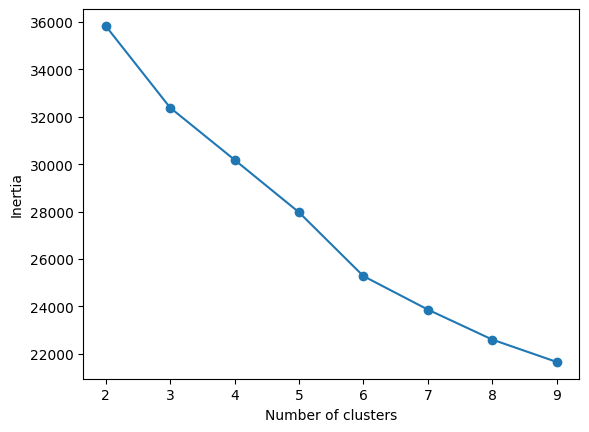

In [31]:
# Find the optimal number of segaments

from sklearn.cluster import KMeans

inertia = []

for k in range(2, 10):
    Kmeans = KMeans(n_clusters=k, random_state=24)
    Kmeans.fit(scaled_data)
    inertia.append(Kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

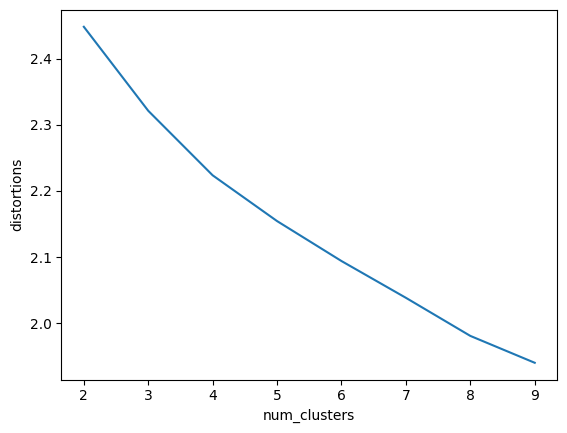

In [32]:
from scipy.cluster.vq import kmeans, vq

distortions = []
num_clusters = range(2, 10)

for i in num_clusters:
    centriods, distortion = kmeans(scaled_data, i)
    distortions.append(distortion)

elbow = pd.DataFrame({
    'num_clusters': num_clusters,
    'distortions': distortions
})

sns.lineplot(x='num_clusters', y='distortions', data = elbow)
plt.show()

In [36]:
# Apply KMeans clustering

kmeans_model = KMeans(n_clusters=4, random_state = 24)

customer_features['clusters'] = kmeans_model.fit_predict(scaled_data)

In [37]:
clusters_summary = customer_features.groupby('clusters').mean().round(2)

print(clusters_summary)

          recency  frequency  monetary  avg_discount  category_diversity  \
clusters                                                                   
0          262.26       1.48   1764.76         74.38                1.39   
1          153.07       2.18   2572.39         63.58                1.96   
2           95.58       2.99   2895.87         45.02                2.53   
3           58.46       6.53  10279.75        105.55                4.68   

          avg_session_duration  avg_pages_viewed  return_rate  avg_rating  
clusters                                                                   
0                        14.65              8.61         0.51        4.33  
1                        14.65              8.90         0.80        2.76  
2                        14.50              9.19         0.90        4.20  
3                        14.51              8.98         0.94        3.87  


In [38]:
customer_features.head(2)

,recency,frequency,monetary,avg_discount,category_diversity,avg_session_duration,avg_pages_viewed,return_rate,avg_rating,clusters
Customer_ID,,,,,,,,,,
CUST_00001,112,3,2199.63,46.016667,3,14.333333,9.0,1.0,3.333333,2
CUST_00002,284,2,809.90,35.525000,2,15.000000,10.0,1.0,4.000000,2


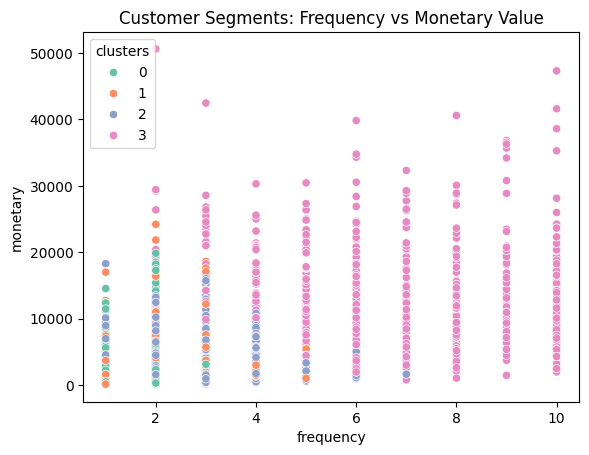

In [39]:
sns.scatterplot(
    data=customer_features,
    x='frequency',
    y='monetary',
    hue='clusters',
    palette= 'Set2'
)

plt.title('Customer Segments: Frequency vs Monetary Value')
plt.show()